In [1]:
import sys, codecs, json, math, time, warnings
warnings.simplefilter( action='ignore', category=FutureWarning )

import nltk, scipy, sklearn, sklearn_crfsuite, sklearn_crfsuite.metrics, eli5
from sklearn.metrics import make_scorer
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display    
import numpy as np

import logging
import tensorflow as tf
import absl.logging
formatter = logging.Formatter('[%(levelname)s|%(filename)s:%(lineno)s %(asctime)s] %(message)s')
absl.logging.get_absl_handler().setFormatter(formatter)
absl.logging._warn_preinit_stderr = False
logger = tf.get_logger()
logger.setLevel(logging.INFO)

In [2]:
## IMPORTANT, RUN BELOW EVERY TIME YOU OPEN TO STOP THE ANNOYING SPACE INDENT WITH NO TABS

In [3]:
 %%javascript

    // apply setting to all current CodeMirror instances
    IPython.notebook.get_cells().map(
        function(c) {  return c.code_mirror.options.indentWithTabs=true;  }
    );

    // make sure new CodeMirror instances created in the future also use this setting
    CodeMirror.defaults.indentWithTabs=true;


<IPython.core.display.Javascript object>

In [4]:
from nltk import pos_tag

In [5]:
#DATE,CARDINAL, ORDINAL, NORP

max_iter = 150
#max_files = 100
display_label_subset = ["B-DATE", "I-DATE", "B-CARDINAL", "I-CARDINAL", "B-ORDINAL", "I-ORDINAL", "B-NORP", "I-NORP"]


In [6]:
all_ner_tags = set()

In [7]:
#experiment with a set of all ner tags to see all the different possible ones

#load ALL the sentences from the ontonotes dataset without splitting

#ignore the POS tags in the ontonotes dataset as we are going to use
#NLTK POS tags instead so that the training instances are the same
#as when we use with the book which will use the NLTK function to
#determine POS tags of tokens
def load_ontonotes_dataset():

	dataset_file = 'ontonotes_parsed.json'
	# load parsed ontonotes dataset
	readHandle = codecs.open( dataset_file, 'r', 'utf-8', errors = 'replace' )
	str_json = readHandle.read()
	readHandle.close()
	dict_ontonotes = json.loads( str_json )
    
	orig_list = list(dict_ontonotes.keys())
    
    #if we have specified a max number smaller than the list size then only read this many files
	#final_list = orig_list[:max_files]#orig_list if max_files > len(orig_list) else orig_list[max_files:]
    
	print("original list length:", len(orig_list))
	#print("final list length:", len(final_list))
    
	sentences = []
	i = 0
    
	for str_file in orig_list :
		print("on file number:", i)
		i += 1
		for str_sent_index in dict_ontonotes[str_file] :
            
            #BELOW, think we should use all as we are just going to work out
            #our own pos tags anyway?
            
			# ignore sents with non-PENN POS tags
			#if 'XX' in dict_ontonotes[str_file][str_sent_index]['pos'] :
			#	continue
			#if 'VERB' in dict_ontonotes[str_file][str_sent_index]['pos'] :
			#	continue
			tokens = []
			ner_tags = []
			# compute IOB tags for named entities (if any)
			ne_type_last = None
            
            #build up the list of tokens and ner tags
			for nTokenIndex in range(len(dict_ontonotes[str_file][str_sent_index]['tokens'])) :
				strToken = dict_ontonotes[str_file][str_sent_index]['tokens'][nTokenIndex]
				strPOS = dict_ontonotes[str_file][str_sent_index]['pos'][nTokenIndex]
				ne_type = None
				if 'ne' in dict_ontonotes[str_file][str_sent_index] :
					dict_ne = dict_ontonotes[str_file][str_sent_index]['ne']
					if not 'parse_error' in dict_ne :
						for str_NEIndex in dict_ne :
							if nTokenIndex in dict_ne[str_NEIndex]['tokens'] :
								ne_type = dict_ne[str_NEIndex]['type']
								break
				if ne_type != None :
					if ne_type == ne_type_last :
						strIOB = 'I-' + ne_type
					else :
						strIOB = 'B-' + ne_type
				else :
					strIOB = 'O'
                    
				all_ner_tags.add(strIOB)            
                    
				ne_type_last = ne_type
				tokens.append(strToken)
				ner_tags.append(strIOB)
				#list_entry.append( ( strToken, strIOB ) )
            
            
			skip = True
            
			for tag in ner_tags:
                #display label subset contains the NER tags that we are looking for
				if tag in display_label_subset:
					skip = False
					break
            
            #this sentence does not contain any of the named entity tags
            #that we are looking for so it is useless, don't bother using it
			#if skip:
				#continue
            
			list_entry = []
            
            #use nltk pos tags instead
			for (index, tup) in enumerate(pos_tag(tokens)):
				#print("tup is:", tup)
				list_entry.append((tup[0], tup[1], ner_tags[index]))
            #here is where we want to inser the NLTK pos tags
			sentences.append( list_entry )
	return sentences

In [8]:
sentences = load_ontonotes_dataset()

original list length: 13109
on file number: 0


KeyboardInterrupt: 

In [9]:
#given a specific NER tag, return 2 sets consisting of the "inside parts" and the "before parts"
def extract_gazetteers(target, sentences):
	before = set()
	inside = set()
	before_tag = "B-" + target
	inside_tag = "I-" + target
	for sent in sentences:
		for tok, _, ner in sent:
			if ner == before_tag:
				before.add(tok.lower())
			if ner == inside_tag:
				inside.add(tok.lower())
	return before, inside

In [52]:
before_name, inside_name = extract_gazetteers("PERSON", wperson)

NameError: name 'wperson' is not defined

In [206]:
len(inside_name)

5672

In [53]:
before_date, inside_date = extract_gazetteers("DATE", wtask3)

In [54]:
len(inside_date)

847

In [55]:
before_cardinal, inside_cardinal = extract_gazetteers("CARDINAL", wtask3)

In [56]:
len(inside_cardinal)

431

In [57]:
before_norp, inside_norp = extract_gazetteers("NORP", wtask3)

In [58]:
before_ord, inside_ord = extract_gazetteers("ORDINAL", wtask3)

In [213]:
len(inside_ord)

20

In [10]:
import pickle

In [14]:
all_ner_tags

set()

In [75]:
#Serialize our modified dataset
#with open("modified_dataset.pkl", "wb") as output:
#    pickle.dump(sentences, output, pickle.HIGHEST_PROTOCOL)

In [11]:
#IMPORTANT, I have already done everything above and saved it as a
#serialized file that can be opened quickly, so just do this instead

with open("modified_dataset.pkl", "rb") as input:
    modified_dataset = pickle.load(input)

In [93]:
len(modified_dataset)

143709

In [147]:
modified_dataset[0]

[('Well', 'RB', 'O'),
 (',', ',', 'O'),
 ('as', 'IN', 'O'),
 ('I', 'PRP', 'O'),
 ('just', 'RB', 'O'),
 ('said', 'VBD', 'O'),
 ('very', 'RB', 'O'),
 ('clearly', 'RB', 'O'),
 (',', ',', 'O'),
 ('that', 'DT', 'O'),
 ('is', 'VBZ', 'O'),
 ('to', 'TO', 'O'),
 ('say', 'VB', 'O'),
 (',', ',', 'O'),
 ('in', 'IN', 'O'),
 ('addition', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('the', 'DT', 'O'),
 ('legal', 'JJ', 'O'),
 ('and', 'CC', 'O'),
 ('historical', 'JJ', 'O'),
 ('complications', 'NNS', 'O'),
 (',', ',', 'O'),
 ('the', 'DT', 'O'),
 ('repeated', 'JJ', 'O'),
 ('change', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('ownership', 'NN', 'O'),
 (',', ',', 'O'),
 ('and', 'CC', 'O'),
 ('then', 'RB', 'O'),
 ('national', 'JJ', 'O'),
 ('sentiments', 'NNS', 'O'),
 ('as', 'IN', 'O'),
 ('well', 'RB', 'O'),
 (',', ',', 'O'),
 ('the', 'DT', 'O'),
 ('four', 'CD', 'B-CARDINAL'),
 ('northern', 'JJ', 'O'),
 ('islands', 'NNS', 'O'),
 ('are', 'VBP', 'O'),
 ('also', 'RB', 'O'),
 ('strategically', 'RB', 'O'),
 ('very', 'RB', 'O'),
 ('i

In [12]:
#convert all the NER tags you don't care about into O's in sentences that may have mixed NER tags that we care about
#with NER tags that we don't care about
def only_Os(desired_set, sentences):
	actual_tags = []
	for tag in desired_set:
		actual_tags.append("B-" + tag)
		actual_tags.append("I-" + tag)
	return [[(tok, pos, ner if ner in actual_tags else 'O') for tok, pos, ner in sent] for sent in sentences]

In [13]:
#If the dataset has already been split and we KNOW that none of these NER tags are the ones we care about,
#then clearly we can just replace ALL NER tags with O
def all_Os(sentences):
	return [[(tok, pos, 'O') for tok, pos, _ in sent] for sent in sentences]

In [14]:
#returns a tuples of 2 lists of sentences, where one list contains all the sentences that contain the tags 
#specified in the argument and the other list does not
#you just give it the tag strings and it adds the Bs and Is for you
def split_tags(tag_set, sentences):
    
    actual_tags = []
    for tag in tag_set:
        actual_tags.append("B-" + tag)
        actual_tags.append("I-" + tag)
    
    contains_tags = []
    doesnt_contain_tags = []
    
    for sent in sentences:
        
        if(any([tag in actual_tags for _,_,tag in sent])):
            contains_tags.append(sent)
        else:
            doesnt_contain_tags.append(sent)
        
    return (contains_tags, doesnt_contain_tags)
    

In [15]:
from random import shuffle
from copy import copy

In [16]:
#take a random sample with the specified size from the list of sentences
def random_sample(sentences, num):
	cp = copy(sentences)
	shuffle(cp)
	return cp[:num]

In [23]:
#use if you want to do training and testing
def random_split(sentences):

	shuffle(sentences)
	#change this to whatever ratio you want it to be
	train_size = int((0.9 * len(sentences)))
	test_size = len(sentences) - train_size
	
	return sentences[:train_size], sentences[-test_size:]

In [24]:
wtask3, wotask3 = split_tags(["DATE", "CARDINAL", "ORDINAL", "NORP"], modified_dataset)
print("number of sentences that contain task 3 NER tags:", len(wtask3))
print("number of sentences that dont contain task 3 NER tags:", len(wotask3))

number of sentences that contain task 3 NER tags: 33300
number of sentences that dont contain task 3 NER tags: 110409


In [19]:
wtask3_test = only_Os(["DATE", "CARDINAL", "ORDINAL", "NORP"], wtask3)

In [20]:
wotask3test = random_sample(all_Os(wotask3), 33300)

In [21]:
task3 = wtask3_test + wotask3test

In [30]:
len(task3)

66600

In [39]:
task3_training, task3_testing = random_split(task3[-50000:])

In [40]:
len(task3_training)

45000

In [41]:
len(task3_testing)

5000

In [139]:
wperson, woperson = split_tags(["PERSON"], modified_dataset)
print("number of senetences that contain PERSON NER tag:", len(wperson))
print("number of sentences that dont contain PERSON NER tag:", len(woperson))

number of senetences that contain PERSON NER tag: 21566
number of sentences that dont contain PERSON NER tag: 122143


In [142]:
wopersonsample = random_sample(woperson, 21566)

In [42]:
#assumed to be in the environment of the function that 
#generates the feature dictionary for task 3
number_gazetteer = set([
	"one", "two", "three", "four", "five", "six", "seven", "eight",
	"nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
	"sixteen", "seventeen", "eighteen", "nineteen", "twenty", "thirty", "fourty", "fifty",
	"sixty", "seventy", "eighty", "ninety", "hundred", "onehundred", "one-hundred", "thousand", "million"
	])

#Python sets are implemented as hash tables so lookup is always around O(1)
#even for large sets

ordinal_gazetteer = set([
	"first", "second", "third", "fourth", "fifth", "sixth", "seventh",
	"eigth", "ninth", "tenth", "eleventh", "twelth", "thirteenth",
	"fourteenth", "fifteenth", "sixteenth", "seventeenth", "eighteenth",
	"nineteenth", "twentieth", "thirtieth", "fourtieth", "fiftieth", 
	"sixtieth", "seventieth", "eightieth", "ninetieth", "hundreth", "thousandth",
	"millionth", "firstly", "secondly", "thirdly", "fourthly", "fifthly", "sixthly", "1st", "2nd", "3rd",
	"4th", "5t"
])

date_gazetteer = set([
    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "day", "week", "month", "year"
    "jan", "january", "feb", "february", "mar", "march", "apr", "april", "may", "jun", "june", "jul", "july",
    "aug", "august", "sep", "september", "oct", "october", "nov", "november", "dec", "december", "holiday", "holidays"
])

time_gazetteer = set(["second", "seconds", "minute", "minutes", "hour", "hours", "time", "clock", "o'clock", "past"])

def is_st_th(candidate):
	suffixes = set(["st", "nd", "rd", "th"])
	return candidate[-2:] in suffixes and candidate[:-2].isdigit()

In [43]:
#generate a feature dictionary for the word at index i in the sentence
def gen_feature_dict_task3(sentence, i):
    
	#token = sentence[i][0]
	#pos_tag = sentence[i][1]

	def gen_features(index, relative_str):
		
		return {
			relative_str + "word.lower()": sentence[index][0].lower(),
			relative_str + "word_prefix": sentence[index][0][:3],
			relative_str + "word_suffix": sentence[index][0][-3:],
			relative_str + "postag": sentence[index][1],
			#relative_str + "postag_prefix": sentence[index][1][:3], think this is useless?
			relative_str + "istitle": sentence[index][0].istitle(),
			relative_str + "isupper": sentence[index][0].isupper(),        
			
		}
	
	#lets say the context window of 3 has extra features to make things more efficient
	def gen_extra_features(index, relative_str):
		return {
			relative_str + "isdigit": sentence[index][0].isdigit(),
			relative_str + "contains_digit": any(char.isdigit() for char in sentence[index][0]), 
			relative_str + "contains_day": "day" in sentence[index][0].lower(),
			
			#python sets are around O(1) lookup so its fine to have large gazetteers
			relative_str + "in_num_gaz": sentence[index][0].lower() in number_gazetteer,
			relative_str + "in_ord_gaz": sentence[index][0].lower() in ordinal_gazetteer,
			relative_str + "in_date_gaz": sentence[index][0].lower() in date_gazetteer,
			relative_str + "in_time_gaz": sentence[index][0].lower() in time_gazetteer,    
			
			#COMMENT THESE OUT MAYBE COS NOT SURE ABOUT THEM
			relative_str + "in_B_date": sentence[index][0].lower() in before_date,
			relative_str + "in_I_date": sentence[index][0].lower() in inside_date,
			relative_str + "in_B_card": sentence[index][0].lower() in before_cardinal,
			relative_str + "in_I_card": sentence[index][0].lower() in inside_cardinal,
			relative_str + "in_B_norp": sentence[index][0].lower() in before_norp,
			relative_str + "in_I_norp": sentence[index][0].lower() in inside_norp,
			relative_str + "in_B_ord": sentence[index][0].lower() in before_ord,
			relative_str + "in_I_ord": sentence[index][0].lower() in inside_ord,
			relative_str + "is_st_th": is_st_th(sentence[index][0])
		}
	
	features = gen_features(i, "")
	features.update(gen_extra_features(i, ""))

	#there is at least 1 word behind
	if i > 0:
		features.update(gen_features(i - 1, "-1:"))
		features.update(gen_extra_features(i - 1, "-1:"))

	#there are at least 2 words behind
	if i > 1:
		features.update(gen_features(i - 2, "-2:"))

	#there is at least 1 word ahead
	if i < len(sentence) - 1:
		features.update(gen_features(i + 1, "+1:"))
		features.update(gen_extra_features(i + 1, "+1:"))
	
	#there are at least 2 words ahead
	if i < len(sentence) - 2:
		features.update(gen_features(i + 2, "+2:"))
	
	return features

In [44]:
#generate a list of feature dictionaries for each word in the sentence
def gen_task3_features(sentence):
	return [gen_feature_dict_task3(sentence, i) for i in range(len(sentence))]

#helper functions
def sent2labels(sentence):
	return [label for _, _, label in sentence] 
def sent2tokens(sent):
	return [token for token, _, _ in sentence]

def sentences2labels(sentences):
	return [sent2labels(sent) for sent in sentences]

In [50]:
#use for custom testing without searches
def train_model(sentences):
	
	#feature dictionaries for each word in a sentence
	feature_lists = [gen_task3_features(sent) for sent in sentences]
	
	#NER labels for each word in a sentence
	label_lists = [sent2labels(sent) for sent in sentences]
	
	crf = sklearn_crfsuite.CRF(
		
		#all these are hyperparameters that can be tuned later
		algorithm = "lbfgs",
        
        #REPLACE YOUR HYPERPARAMETERS HERE
		c1 = 0.18681659036684042,
		c2 = 0.05558679310114803,
		
		max_iterations = max_iter,
		all_possible_transitions=False,
		verbose = True
	)
	
	crf.fit(feature_lists, label_lists)
	
	labels = list(crf.classes_).remove('O')
	
	return crf

In [46]:
import scipy
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV

In [29]:
def optimize(sentences):
    
    #feature dictionaries for each word in a sentence
    feature_lists = [gen_task3_features(sent) for sent in sentences]

#NER labels for each word in a sentence
    label_lists = [sent2labels(sent) for sent in sentences]
    
    crf = sklearn_crfsuite.CRF(
        algorithm = "lbfgs",
        max_iterations = max_iter,
        verbose = False
    )
    
    params_space = {
        'c1': scipy.stats.expon(scale = 1),
        'c2': scipy.stats.expon(scale = 0.1)
    }
    
    f1_scorer = make_scorer(metrics.flat_f1_score, average = "weighted", labels = display_label_subset)
    
    rs = RandomizedSearchCV(
        crf,
        params_space,
        cv = 2,
        verbose = 20,
        n_jobs = -1,
        n_iter = 50,
        scoring = f1_scorer
    )
    
    rs.fit(feature_lists, label_lists)
    return rs

In [33]:
search_result = optimize(reduced)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  9

In [34]:
search_result.best_score_

0.6972531426430062

In [35]:
search_result.best_params_

{'c1': 0.18681659036684042, 'c2': 0.05558679310114803}

In [59]:
search_result.__dict__

{'param_distributions': {'c1': <scipy.stats._distn_infrastructure.rv_frozen at 0x1dbe80ee3a0>,
  'c2': <scipy.stats._distn_infrastructure.rv_frozen at 0x1db83cee670>},
 'n_iter': 50,
 'random_state': None,
 'scoring': make_scorer(flat_f1_score, average=weighted, labels=['B-DATE', 'I-DATE', 'B-CARDINAL', 'I-CARDINAL', 'B-ORDINAL', 'I-ORDINAL', 'B-NORP', 'I-NORP', 'B-PERSON', 'I-PERSON']),
 'estimator': CRF(algorithm='lbfgs', keep_tempfiles=None, max_iterations=150),
 'n_jobs': -1,
 'iid': 'deprecated',
 'refit': True,
 'cv': 2,
 'verbose': 20,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'multimetric_': False,
 'best_index_': 7,
 'best_score_': 0.6972531426430062,
 'best_params_': {'c1': 0.18681659036684042, 'c2': 0.05558679310114803},
 'best_estimator_': CRF(algorithm='lbfgs', c1=0.18681659036684042, c2=0.05558679310114803,
     keep_tempfiles=None, max_iterations=150),
 'refit_time_': 229.81149244308472,
 'scorer_': make_scorer(flat_f1_score, averag

In [49]:
def report(trained_model, testing_sentences):
    print("TRANSITION WEIGHTS LEARNT ON DATASET:")
    display( eli5.show_weights(trained_model, top=(30,30), targets = display_label_subset, show=['transition_features']))
    print("BEST PERFORMING FEATURES FOR EACH NER TAG:")
    display( eli5.show_weights(trained_model, top=(30,30), targets = display_label_subset, show=['targets']) )

    #needs to be changed for task 4, this can only really be used with task 3
    ner_labels = ["B-DATE", "I-DATE", "B-CARDINAL", "I_CARDINAL", "B-ORDINAL", "I-ORDINAL", "B-NORP", "I-NORP"]

    y_features = [gen_task3_features(sent) for sent in testing_sentences]
    y_labels = [sent2labels(sent) for sent in testing_sentences]
    y_pred = res.predict(y_features)

    sorted_labels = sorted(
        ner_labels,
        key = lambda name: (name[1:], name[0])
    )
    print(metrics.flat_classification_report(
        y_labels, y_pred, labels = sorted_labels, digits = 3
    ))
    
    """
    #testing_data = gen_task3_features(testing_data)
    #testing_labels = sentences2labels(testing_data)    

    #testing_data = [gen_task3_features(sent) for sent in testing_sentences]
    #testing_labels = [sent2labels(sent) for sent in testing_sentences]

    # compute the macro F1 score (F1 for instances of each label class averaged) in the test set
    #predictions = trained_model.predict(testing_data)
	#the named labels
    sorted_labels = sorted(
        ner_labels, 
        key=lambda name: (name[1:], name[0])
    )
    macro_scores = sklearn_crfsuite.metrics.flat_classification_report(testing_data, predictions, labels=sorted_labels, digits=3, output_dict = True )
	"""

In [ ]:
def show_top_features(trained_model):
	

In [69]:
search_result.estimator.__dict__

{'algorithm': 'lbfgs',
 'min_freq': None,
 'all_possible_states': None,
 'all_possible_transitions': None,
 'c1': None,
 'c2': None,
 'max_iterations': 150,
 'num_memories': None,
 'epsilon': None,
 'period': None,
 'delta': None,
 'linesearch': None,
 'max_linesearch': None,
 'calibration_eta': None,
 'calibration_rate': None,
 'calibration_samples': None,
 'calibration_candidates': None,
 'calibration_max_trials': None,
 'pa_type': None,
 'c': None,
 'error_sensitive': None,
 'averaging': None,
 'variance': None,
 'gamma': None,
 'modelfile': <sklearn_crfsuite._fileresource.FileResource at 0x1dbe80b5b20>,
 'verbose': False,
 'trainer_cls': None,
 'training_log_': None,
 '_tagger': None,
 '_info_cached': None}

In [60]:
search_result.estimator

CRF(algorithm='lbfgs', keep_tempfiles=None, max_iterations=150)

In [59]:
res = train_model(task3_training)

loading training data to CRFsuite: 100%|████████████████████████████████████████| 45000/45000 [02:07<00:00, 352.25it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 336022
Seconds required: 12.739

L-BFGS optimization
c1: 0.186817
c2: 0.055587
num_memories: 6
max_iterations: 150
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=6.41  loss=916371.14 active=333334 feature_norm=1.00
Iter 2   time=3.17  loss=441595.15 active=327092 feature_norm=2.93
Iter 3   time=3.20  loss=412431.48 active=326587 feature_norm=2.76
Iter 4   time=6.34  loss=348936.99 active=220240 feature_norm=2.28
Iter 5   time=3.17  loss=310600.75 active=277260 feature_norm=2.67
Iter 6   time=3.29  loss=276816.05 active=271090 feature_norm=2.81
Iter 7   time=3.18  loss=211687.96 active=216096 feature_norm=4.08
Iter 8   time=3.13  loss=183816.94 active=219725 feature_norm=5.09
Iter 9   time=3.18  loss=167376.99 active=217905 feature_norm

Iter 124 time=3.01  loss=14909.39 active=63739 feature_norm=161.80
Iter 125 time=3.02  loss=14908.14 active=63643 feature_norm=161.89
Iter 126 time=3.04  loss=14888.68 active=63549 feature_norm=161.97
Iter 127 time=3.01  loss=14888.44 active=63453 feature_norm=162.05
Iter 128 time=3.01  loss=14869.15 active=63357 feature_norm=162.13
Iter 129 time=6.03  loss=14859.82 active=63357 feature_norm=162.17
Iter 130 time=3.02  loss=14858.74 active=63179 feature_norm=162.22
Iter 131 time=3.04  loss=14845.02 active=63092 feature_norm=162.30
Iter 132 time=3.04  loss=14834.63 active=62959 feature_norm=162.37
Iter 133 time=3.05  loss=14819.96 active=62913 feature_norm=162.46
Iter 134 time=3.02  loss=14809.19 active=62807 feature_norm=162.51
Iter 135 time=3.01  loss=14793.75 active=62732 feature_norm=162.57
Iter 136 time=3.02  loss=14789.01 active=62578 feature_norm=162.62
Iter 137 time=3.02  loss=14771.26 active=62577 feature_norm=162.67
Iter 138 time=3.01  loss=14767.77 active=62439 feature_norm=16

In [62]:
report(res, task3_testing)

TRANSITION WEIGHTS LEARNT ON DATASET:


From \ To,B-DATE,I-DATE,B-CARDINAL,I-CARDINAL,B-ORDINAL,I-ORDINAL,B-NORP,I-NORP
B-DATE,0.0,6.092,-2.567,0.0,-4.785,0.0,-1.911,0.0
I-DATE,0.0,6.928,-2.563,0.0,-3.373,0.0,-1.763,0.0
B-CARDINAL,1.526,0.0,0.0,10.631,-0.549,0.0,1.5,0.0
I-CARDINAL,-0.263,0.0,0.0,10.393,0.0,0.0,-0.018,0.0
B-ORDINAL,3.215,0.0,0.997,0.0,0.0,6.165,0.083,0.0
I-ORDINAL,0.0,0.0,0.0,0.0,0.0,5.821,0.0,0.0
B-NORP,0.078,0.0,-0.427,0.0,0.0,0.0,0.0,6.699
I-NORP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.879


BEST PERFORMING FEATURES FOR EACH NER TAG:


ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [37]:
#THESE 2 THAT YOU CAN SEE BELOW ARE THE SCORES AND PARAMETERS TRIED
#WE CAN USE THESE FOR MAKING A GRAPH

(search_result.cv_results_["mean_test_score"])

array([0.64700766, 0.63778492, 0.69018746, 0.69509842, 0.69575334,
       0.66168052, 0.67862594, 0.69725314, 0.69330478, 0.69233064,
       0.69081366, 0.68203801, 0.68539595, 0.68264971, 0.69418499,
       0.69653619, 0.69446661, 0.6944963 , 0.69028377, 0.69493699,
       0.69509816, 0.69521489, 0.68565829, 0.65707126, 0.6911778 ,
       0.67167664, 0.69694339, 0.69279926, 0.66460145, 0.68518864,
       0.69341737, 0.69328956, 0.69501531, 0.69558753, 0.67024621,
       0.69148524, 0.649063  , 0.69076171, 0.69584398, 0.69476678,
       0.66247766, 0.69186819, 0.69244898, 0.69666378, 0.69251896,
       0.6941628 , 0.69011813, 0.69533278, 0.66154253, 0.67329329])

In [38]:
(search_result.cv_results_["params"])

[{'c1': 2.9648115006545948, 'c2': 0.002770954189844922},
 {'c1': 3.050149626240832, 'c2': 0.11776279653474848},
 {'c1': 0.7988145023868894, 'c2': 0.029990111312719715},
 {'c1': 0.5198765586942998, 'c2': 0.06190494104499919},
 {'c1': 0.11052365586496928, 'c2': 0.03319644953241539},
 {'c1': 2.33625058922093, 'c2': 0.029758633102114254},
 {'c1': 1.2384457402496012, 'c2': 0.21327260011431412},
 {'c1': 0.18681659036684042, 'c2': 0.05558679310114803},
 {'c1': 0.4118427741466733, 'c2': 0.302638056210277},
 {'c1': 0.5280650311884291, 'c2': 0.03491081587036931},
 {'c1': 0.37640168481110103, 'c2': 0.007121581917592267},
 {'c1': 1.3340648700260498, 'c2': 0.02798587296560002},
 {'c1': 1.0626417808992044, 'c2': 0.09227043107640265},
 {'c1': 1.0814249336654451, 'c2': 0.05148271779468913},
 {'c1': 0.604058814295287, 'c2': 0.03833310624089782},
 {'c1': 0.0941502380757118, 'c2': 0.014184444877007183},
 {'c1': 0.33842139014619393, 'c2': 0.061506953652100085},
 {'c1': 0.6439023113449283, 'c2': 0.03949264

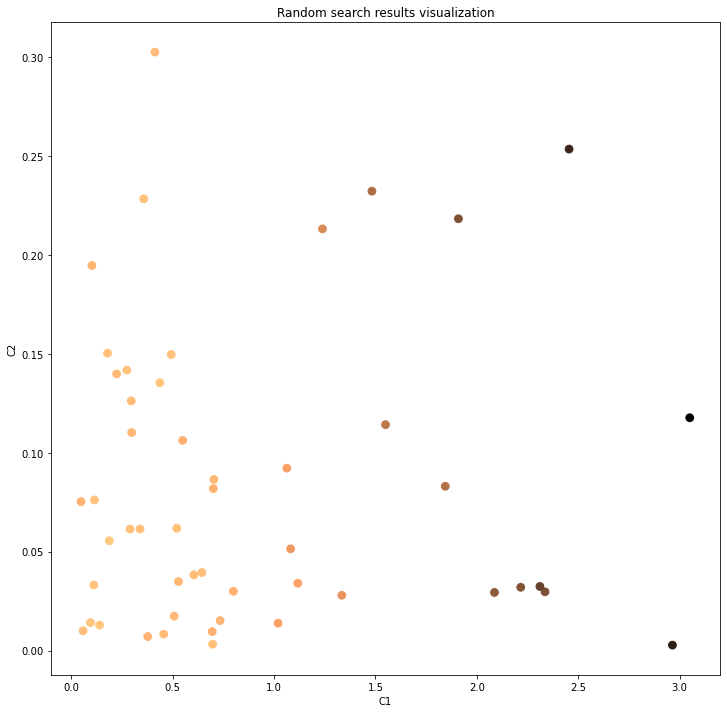

In [51]:
import matplotlib.pyplot as plt

_x = [dct["c1"] for dct in search_result.cv_results_["params"]]
_y = [dct["c2"] for dct in search_result.cv_results_["params"]]
_c = search_result.cv_results_["mean_test_score"].tolist()

print("BLACK IS WORSE, YELLOWER IS BETTER")

fig = plt.figure()
fig.set_size_inches(12,12)
ax = plt.gca()
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("C1")
ax.set_ylabel("C2")
ax.set_title("Random search results visualization")
ax.scatter(_x,_y, c = _c, s = 60, cmap = "copper")

In [58]:
_y

[0.40651328971749595,
 0.04336832776525428,
 0.02334841244445546,
 0.03551945816520938,
 0.07836470599223073,
 0.06978744998789964,
 0.10492186320536755,
 0.030245171082205338,
 0.05263153223978084,
 0.0694628056754573,
 0.251961256212934,
 0.10997703026194197,
 0.02781109185740604,
 0.20668377233965593,
 0.11698692904275175,
 0.032122511980546366,
 0.02753627320870332,
 0.0019779971432934453,
 0.22505333535297725,
 0.08014869586137813,
 0.0977208306221014,
 0.11359477934076714,
 0.036977550808653115,
 0.24367731655950065,
 0.12673782080857277,
 0.021180434772432984,
 0.12215621833992192,
 0.07633314287238879,
 0.17118983783218955,
 0.09690304606970206,
 0.23896201050934535,
 0.21977764521860307,
 0.045841368884904546,
 0.12600407093348664,
 0.024436238496662585,
 0.11577355792802063,
 0.2152488687617464,
 0.6275956555667136,
 0.01589136864914692,
 0.15191797162713028,
 0.25643034517466706,
 0.00636069916414636,
 0.07664782209187697,
 0.000675815997363042,
 0.015240195110155771,
 0.181

In [31]:
shuffle(modified_dataset)

In [32]:
#how many sentences to use
reduced = modified_dataset[:10000]

In [16]:
%%time
crf = train_model(reduced, True)

loading training data to CRFsuite:  27%|██████████▊                             | 2714/10000 [00:01<00:03, 1966.37it/s]


KeyboardInterrupt: 

In [59]:
labels = list(crf.classes_)
labels.remove('O')

In [63]:
y_features = [gen_task3_features(sent) for sent in task3_testing]
y_labels = [sent2labels(sent) for sent in task3_testing]
y_pred = res.predict(y_features)

sorted_labels = sorted(
    display_label_subset,
    key = lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_labels, y_pred, labels = sorted_labels, digits = 3
))

              precision    recall  f1-score   support

  B-CARDINAL      0.799     0.830     0.814      1029
  I-CARDINAL      0.796     0.744     0.769       336
      B-DATE      0.856     0.839     0.847      1820
      I-DATE      0.865     0.859     0.862      2176
      B-NORP      0.932     0.906     0.919       823
      I-NORP      0.877     0.838     0.857        68
   B-ORDINAL      0.788     0.812     0.800       234
   I-ORDINAL      0.000     0.000     0.000         3

   micro avg      0.853     0.847     0.850      6489
   macro avg      0.739     0.729     0.734      6489
weighted avg      0.854     0.847     0.850      6489



In [63]:
y_pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PERCENT',
  'I-PERCENT',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'I-ORG',
  'B-DATE',
  'I-DATE',
  'I-DATE'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['B-LOC',
  'I-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-GPE',
  'O'],
 ['O',
  'B-PERSON',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-NORP',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'B-QUANTITY', 'I-QUANTITY', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'B

In [255]:
from sklearn_crfsuite import metrics

In [256]:
sorted_labels = sorted(
    display_label_subset,
    key = lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_labels, y_pred, labels = sorted_labels, digits = 3
))

              precision    recall  f1-score   support

  B-CARDINAL      0.809     0.823     0.816      1368
  I-CARDINAL      0.749     0.741     0.745       468
      B-DATE      0.865     0.852     0.858      2398
      I-DATE      0.860     0.858     0.859      2845
      B-NORP      0.920     0.897     0.909      1185
      I-NORP      0.844     0.760     0.800       100
   B-ORDINAL      0.768     0.793     0.780       246
   I-ORDINAL      0.000     0.000     0.000         3

   micro avg      0.852     0.847     0.849      8613
   macro avg      0.727     0.716     0.721      8613
weighted avg      0.853     0.847     0.849      8613

